In [2]:
import pandas as pd
import numpy as np
from plan import *
from testing import generate_all_single
import matplotlib.pyplot as plt

In [3]:
data = Dataset()

#### Utility Functions

In [4]:
output_base_path = "F:\SHRINIVAS\KGP\BTP\Meal-Planning\Outputs\\"

In [5]:
df = pd.read_csv(output_base_path+"single_objective\Weights1.tsv",sep='\t')

In [6]:
df.head()

,Dish 1 id,Dish 1 qty,Dish 2 id,Dish 2 qty,Dish 3 id,Dish 3 qty,Dish 4 id,Dish 4 qty,Dish 5 id,Dish 5 qty,...,Dish 11 qty,Dish 12 id,Dish 12 qty,Dish 13 id,Dish 13 qty,Dish 14 id,Dish 14 qty,Dish 15 id,Dish 15 qty,Cfg Id
0,2023,1,0,0,0,0,4331,1,3258,1,...,2,3045,2,6698,2,0,0,0,0,0
1,5947,1,0,0,0,0,4331,1,3258,1,...,2,3045,2,6698,2,0,0,0,0,0
2,3154,1,0,0,0,0,4331,1,3258,1,...,2,3045,2,6698,2,0,0,0,0,0
3,3796,1,0,0,0,0,4331,1,3258,1,...,2,3045,2,6698,2,0,0,0,0,0
4,3663,1,0,0,0,0,4331,1,3258,1,...,2,3045,2,6698,2,0,0,0,0,0


In [7]:
all_dishes = df

In [8]:
all_single = generate_all_single()

In [9]:
def get_meal_plans(base_path,file_name,all_single):
    df = pd.read_csv(output_base_path+f"{base_path}/{file_name}.tsv",sep='\t')
    all_data = df.values
    meal_plans: list[MealPlan] = []
    for plan_id,plan in enumerate(all_data):
        meal_plan = []
        for i in range(0,len(plan)-1,2):
            dish_index = i//2
            dish_id = plan[i]
            dish_qty = plan[i+1]
            meal = "Breakfast"
            if dish_index > 2 and dish_index <= 7:
                meal = "Lunch"
            elif dish_index > 7 and dish_index <= 9:
                meal = "Snacks"
            elif dish_index > 9:
                meal = "Dinner"
            if dish_id == 0:
                dish = Dish.get_padding_dish()
            else:
                dish = Dish(
                    id = str(dish_id),
                    quantity = dish_qty,
                    vector = data.get_dish_vector(dish_id),
                    title = data.get_dish_title(dish_id),
                    meal = meal,
                    cuisine = data.get_dish_cuisine(dish_id),
                    tags = data.get_dish_cuisine(dish_id),
                    category = data.get_dish_category(dish_id)
                )
            meal_plan.append(dish)
        cfg_id = plan[-1]
        problem_config=ProblemConfig(**all_single[cfg_id])
        meal_plans.append(MealPlan(problem_config,data,meal_plan))
    return meal_plans

Cuisine Factor

In [10]:
cuisines=['North America', 'United States', 'Europe', 'Italy',
            'Middle East', 'South East Asia', 'Canada', 'France', 'Mexico',
            'British Isles', 'Australia & NZ', 'Greece', 'Eastern Europe',
            'Asia', 'South America', 'China', 'Japan', 'Africa',
            'Indian Subcontinent', 'Korea']

In [11]:
cuisine_matrix = np.zeros((len(cuisines),len(cuisines)))

In [12]:
one_dist = [
    ["North America","United States"],
    ["North America","Canada"],
    ["Europe","Italy"],
    ["Europe","France"],
    ["Europe","Mexico"],
    ["Europe","British Isles"],
    ["Europe", "Greece"],
    ["Europe","Eastern Europe"],
    ["Asia","Middle East"],
    ["Asia","China"],
    ["Asia","Japan"],
    ["Asia","South East Asia"],
    ["Asia","Korea"]
]

two_dist = [
    ["United States","Canada"],
    ["Italy","France"],
    ["Greece","Eastern Europe"],
]

three_dist = [
    ["Japan","China"],
    ["China","Korea"],
    ["Japan","Korea"]
]

In [13]:
for cid1, cuisine1 in enumerate(cuisines):
    for cid2, cuisine2 in enumerate(cuisines):
        if cid1 == cid2:
            cuisine_matrix[cid1][cid2]=0
        elif [cuisine1,cuisine2] in one_dist or [cuisine2,cuisine1] in one_dist:
            cuisine_matrix[cid1][cid2]=1
            cuisine_matrix[cid2][cid1]=1
        elif [cuisine1,cuisine2] in two_dist or [cuisine2,cuisine1] in two_dist:
            cuisine_matrix[cid1][cid2]=2
            cuisine_matrix[cid2][cid1]=2
        elif [cuisine1,cuisine2] in three_dist or [cuisine2,cuisine1] in three_dist:
            cuisine_matrix[cid1][cid2]=3
            cuisine_matrix[cid2][cid1]=3
        else:
            cuisine_matrix[cid1][cid2]=5
            cuisine_matrix[cid2][cid1]=5

In [14]:
def get_cuisine_score(meal_plan:list[Dish]):
    cnt = 0 
    value = 0
    for id1 in range(0,len(meal_plan)):
        if meal_plan[id1].id == 0:
            continue
        for id2 in range(id1 + 1, len(meal_plan)):
            if meal_plan[id2].id == 0 or meal_plan[id1].meal != meal_plan[id2].meal:
                continue
            if meal_plan[id1].cuisine==-1 or meal_plan[id2].cuisine==-1:
                continue
            cnt += 1
            cid1 = cuisines.index(meal_plan[id1].cuisine)
            cid2 = cuisines.index(meal_plan[id2].cuisine)
            value += cuisine_matrix[cid1][cid2] / 5
    if cnt == 0:
        return 0
    return value / cnt

Course Constraint

In [15]:
df_dishes=pd.read_csv("./Data/Processed/dishes.csv")

In [16]:
df_dishes['Category'].unique()

array(['appetizer', 'dessert', 'main-dish'], dtype=object)

In [17]:
def get_course_scores(meal_plan:list[Dish]):
    breakfast_dishes = []
    lunch_dishes = []
    snacks_dishes = []
    dinner_dishes = []
    for dish_id, dish in enumerate(meal_plan):
        if dish_id <= 2:
            breakfast_dishes.append(dish.category)
        elif dish_id <= 7:
            lunch_dishes.append(dish.category)
        elif dish_id <= 9:
            snacks_dishes.append(dish.category)
        else:
            dinner_dishes.append(dish.category)
    breakfast_score = 0
    if ('appetizer' in breakfast_dishes or 'dessert' in breakfast_dishes) and 'main-dish' not in breakfast_dishes:
        breakfast_score = 1
    lunch_score = 0
    if 'appetizer' in lunch_dishes and ('main-dish' in lunch_dishes or len([val for val in lunch_dishes if val=='appetizer'])==2):
        lunch_score = 1
    snacks_score = 0
    if ('appetizer' in snacks_dishes or 'dessert' in snacks_dishes) and 'main-dish' not in snacks_dishes:
        snacks_score = 1
    dinner_score = 0
    if 'appetizer' in dinner_dishes and ('main-dish' in dinner_dishes or len([val for val in dinner_dishes if val=='appetizer'])==2):
        dinner_score = 1
    overall_score = (breakfast_score + lunch_score + snacks_score + dinner_score ) / 4

    return {
        "breakfast": breakfast_score,
        "lunch": lunch_score,
        "snacks": snacks_score,
        "dinner": dinner_score,
        "overall": overall_score
    }

In [20]:
def evaluate_meal_plans(meal_plans):
    avg_res = {
        "diversity": 0,
        "combination": 0,
        "preference": 0,
        "cuisine": 0,
        "breakfast": 0,
        "lunch": 0,
        "snacks": 0,
        "dinner": 0,
        "overall": 0
    }
    for meal_plan in meal_plans:
        avg_res["diversity"]+=meal_plan.get_diversity()
        avg_res["combination"]+=meal_plan.get_combi_value()
        avg_res["preference"]+=meal_plan.get_pos_preference() - meal_plan.get_neg_preference()
        avg_res["cuisine"]+=get_cuisine_score(meal_plan.plan)
        course_scores = get_course_scores(meal_plan.plan)
        avg_res["breakfast"]+=course_scores["breakfast"]
        avg_res["lunch"]+=course_scores["lunch"]
        avg_res["snacks"]+=course_scores["snacks"]
        avg_res["dinner"]+=course_scores["dinner"]
        avg_res["overall"]+=course_scores["overall"]

    for k,v in avg_res.items():
        avg_res[k]/=len(meal_plans)
    return avg_res

#### Weighted Sum

In [21]:
res = []
for id in range(1,9):
    meal_plans = get_meal_plans("single_objective",f"Weights{id}",all_single)
    avg_res = {
        "title": f"Weights{id}",
    }
    avg_res.update(evaluate_meal_plans(meal_plans))
    res.append(avg_res)

In [22]:
result_df_weights = pd.DataFrame(res)
result_df_weights.head(10)

,title,diversity,combination,preference,cuisine,breakfast,lunch,snacks,dinner,overall
0,Weights1,0.691377,0.897822,0.752455,0.161193,0.712,0.644,1.000,0.732,0.77200
1,Weights2,0.661696,0.952478,0.689980,0.127042,0.748,0.664,0.988,0.720,0.78000
2,Weights3,0.782049,0.864717,0.696292,0.222373,0.790,0.900,0.985,0.750,0.85625
3,Weights4,0.664922,0.795437,0.876289,0.169560,0.792,0.716,1.000,0.584,0.77300
4,Weights5,0.738587,0.939691,0.625570,0.096277,0.780,0.788,1.000,0.776,0.83600
5,Weights6,0.632133,0.919061,0.782912,0.138330,0.792,0.560,1.000,0.744,0.77400
6,Weights7,0.740400,0.746562,0.853268,0.203270,0.728,0.824,0.992,0.696,0.81000
7,Weights8,0.666146,0.837694,0.876512,0.130546,0.805,0.815,1.000,0.655,0.81875


#### Ablation Study

In [ ]:
res = []
for id in range(1,9):
    meal_plans = get_meal_plans("ablation_study",f"Ablation_Study{id}",all_single)
    avg_res = {
        "title": f"Ablation_Study{id}",
    }
    avg_res.update(evaluate_meal_plans(meal_plans))
    res.append(avg_res)

In [ ]:
result_df_ablation = pd.DataFrame(res)
result_df_ablation.head(10)

,title,diversity,combination,preference,cuisine,breakfast,lunch,snacks,dinner,overall
0,Ablation_Study1,0.540960,0.918864,-0.002701,0.253069,0.647826,0.621739,0.969565,0.569565,0.702174
1,Ablation_Study2,0.977003,0.142610,-0.013995,0.698840,0.904545,0.690909,0.977273,0.727273,0.825000
2,Ablation_Study3,0.551803,0.993453,-0.005714,0.167015,0.716279,0.218605,0.995349,0.418605,0.587209
3,Ablation_Study4,0.796055,0.913330,0.046469,0.200497,0.681633,0.865306,0.991837,0.742857,0.820408
4,Ablation_Study5,0.519974,0.562829,0.966968,0.102676,0.826087,0.730435,1.000000,0.708696,0.816304
5,Ablation_Study6,0.922766,0.222284,0.623344,0.553320,0.767347,0.710204,0.995918,0.661224,0.783673
6,Ablation_Study7,0.540582,0.941787,0.628249,0.140792,0.888372,0.623256,1.000000,0.562791,0.768605
7,Ablation_Study8,0.832984,0.678531,0.451243,0.484705,0.792000,0.736000,0.996000,0.728000,0.813000


### Observations

In [22]:
weighted_meal_plans = get_meal_plans("single_objective",f"Weights1",all_single)
ablation_meal_plans = get_meal_plans("ablation_study",f"Ablation_Study8",all_single)

In [23]:
for dish in weighted_meal_plans[0].plan:
    print(dish)
print(weighted_meal_plans[0].evaluate_plan())

Spinach Quiche : 1 : -1 : main-dish : -1


Karyn'S Cream Of Crab Soup : 1 : United States : appetizer : United States
Beef Samosas : 1 : Indian Subcontinent : appetizer : Indian Subcontinent
Gujarati Carrot And Peanut Salad : 2 : Indian Subcontinent : appetizer : Indian Subcontinent


Yummy Potato Skins : 1 : Canada : appetizer : Canada

Indian Chickpeas : 2 : Indian Subcontinent : main-dish : Indian Subcontinent
Chocolate Spiders : 2 : -1 : dessert : -1
Bombay Chicken Wings : 2 : Indian Subcontinent : appetizer : Indian Subcontinent


[0.8315449555714926, 0.7224250354279808, 0.5833333333333334, 0.0]


In [24]:
for dish in weighted_meal_plans[2].plan:
    print(dish)
print(weighted_meal_plans[2].evaluate_plan())

Shredded Potato Quiche : 1 : -1 : main-dish : -1


Karyn'S Cream Of Crab Soup : 1 : United States : appetizer : United States
Beef Samosas : 1 : Indian Subcontinent : appetizer : Indian Subcontinent
Gujarati Carrot And Peanut Salad : 2 : Indian Subcontinent : appetizer : Indian Subcontinent


Ice Cream Kolacky : 1 : Eastern Europe : dessert : Eastern Europe

Indian Chickpeas : 2 : Indian Subcontinent : main-dish : Indian Subcontinent
Chocolate Spiders : 2 : -1 : dessert : -1
Bombay Chicken Wings : 2 : Indian Subcontinent : appetizer : Indian Subcontinent


[0.8315449555714926, 0.7224250354279808, 0.5833333333333334, 0.0]


In [25]:
print(sum(weighted_meal_plans[0].evaluate_plan()))
print(sum(weighted_meal_plans[2].evaluate_plan()))

2.1373033243328066
2.1373033243328066


In [26]:
for dish in ablation_meal_plans[0].plan:
    print(dish)

Date Nut Bread : 1 : -1 : appetizer : -1


Scotch Eggs : 2 : British Isles : appetizer : British Isles
Irish Potato Candy : 2 : British Isles : dessert : British Isles
Irish Bacon And Cabbage Soup : 2 : British Isles : appetizer : British Isles


Butterscotch Squares : 1 : Canada : dessert : Canada

Tom Ka Gai (Coconut Chicken Soup) : 2 : South East Asia : main-dish : South East Asia
Chocolate Chai : 2 : Indian Subcontinent : main-dish : Indian Subcontinent
Chocolate Spiders : 2 : -1 : dessert : -1




In [27]:
for dish in ablation_meal_plans[1].plan:
    print(dish)

Omelet In A Bag : 1 : France : main-dish : France


Stuffed Tomatoes : 2 : Indian Subcontinent : appetizer : Indian Subcontinent
Corn Tortillas : 1 : Mexico : appetizer : Mexico
Buckeye Balls Ii : 1 : United States : dessert : United States


Peanut Clusters : 2 : -1 : dessert : -1

Caramelized Chicken Wings : 1 : -1 : main-dish : -1
Fortune Cookies I : 1 : China : dessert : China
Chocolate Spiders : 2 : -1 : dessert : -1
Bombay Chicken Wings : 2 : Indian Subcontinent : appetizer : Indian Subcontinent



In [24]:
print(all_single[0]['groups'][0]['positive_preferences'])
print(all_single[0]['groups'][0]['negative_preferences'])

['Indian Subcontinent']
['China']


In [28]:
print(result_df_ablation.iloc[-1])

title          Ablation_Study8
diversity             0.833959
combination           0.679584
preference            0.401553
cuisine                0.48284
breakfast             0.808511
lunch                 0.668085
snacks                0.991489
dinner                0.744681
overall               0.803191
Name: 7, dtype: object


In [32]:
print(result_df_weights.iloc[2])

title          Weights3
diversity      0.782049
combination    0.864717
preference     0.696292
cuisine        0.222373
breakfast          0.79
lunch               0.9
snacks            0.985
dinner             0.75
overall         0.85625
Name: 2, dtype: object


### Comparing Best scores

In [41]:
def get_best_scores(base_path,file_name,all_single):
    df = pd.read_csv(output_base_path+f"{base_path}/{file_name}.tsv",sep='\t')
    all_data = df.values
    cfg_to_score = {}
    #   "overall": 0,
    #   "cuisine": 0,
    #   "diversity": 0,
    #   "combination": 0,
    #   "preference": 0,
    for plan_id,plan in enumerate(all_data):
        meal_plan = []
        for i in range(0,len(plan)-1,2):
            dish_index = i//2
            dish_id = plan[i]
            dish_qty = plan[i+1]
            meal = "Breakfast"
            if dish_index > 2 and dish_index <= 7:
                meal = "Lunch"
            elif dish_index > 7 and dish_index <= 9:
                meal = "Snacks"
            elif dish_index > 9:
                meal = "Dinner"
            if dish_id == 0:
                dish = Dish.get_padding_dish()
            else:
                dish = Dish(
                    id = str(dish_id),
                    quantity = dish_qty,
                    vector = data.get_dish_vector(dish_id),
                    title = data.get_dish_title(dish_id),
                    meal = meal,
                    cuisine = data.get_dish_cuisine(dish_id),
                    tags = data.get_dish_cuisine(dish_id),
                    category = data.get_dish_category(dish_id)
                )
            meal_plan.append(dish)
        cfg_id = plan[-1]
        
        problem_config=ProblemConfig(**all_single[cfg_id])
        meal_plan = MealPlan(problem_config,data,meal_plan)
        course_res = get_course_scores(meal_plan.plan)
        cuisine_res = get_cuisine_score(meal_plan.plan)
        if cfg_id not in cfg_to_score or ( cfg_to_score[cfg_id]["overall"] + cfg_to_score[cfg_id]["cuisine"] < course_res["overall"]+cuisine_res):
            cfg_to_score[cfg_id] = {
                "combination": meal_plan.get_combi_value(),
                "diversity": meal_plan.get_diversity(),
                "overall": course_res["overall"],
                "cuisine": 1 - cuisine_res
            }
    return cfg_to_score

In [59]:
cfg_to_score_single = get_best_scores("single_objective","Weights3",all_single)
cfg_to_score_ablation = get_best_scores("ablation_study","Ablation_Study8",all_single)

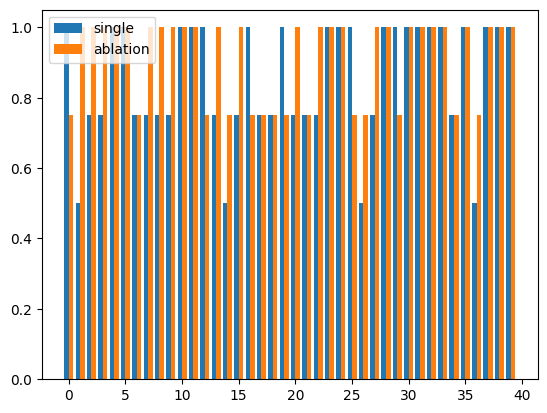

In [68]:
overall_single = [val["overall"] for key,val in cfg_to_score_multi.items() if key < 40]
overall_ablation = [val["overall"] for key,val in cfg_to_score_ablation.items() if key < 40]
bar_width = 0.4
x_pos = np.array(list(range(len(overall_single))))
plt.bar(x_pos - bar_width/2,width=bar_width,height=overall_single,label = 'single')
plt.bar(x_pos + bar_width/2,width=bar_width,height=overall_ablation,label = 'ablation')
plt.legend()
plt.show()

In [71]:
cnt_better_single = 0
cnt_better_ablation = 0
for indx in range(len(overall_single)):
    if overall_single[indx] <= overall_ablation[indx]:
        cnt_better_ablation += 1
    if overall_single[indx] >= overall_ablation[indx]:
        cnt_better_single += 1
cnt_better_ablation, cnt_better_single

(34, 26)

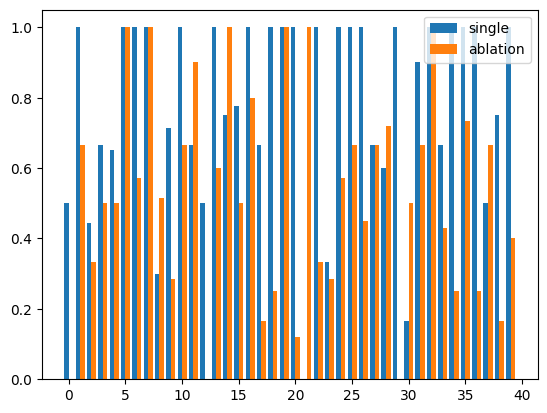

In [72]:
cuisine_single = [val["cuisine"] for key,val in cfg_to_score_multi.items() if key < 40]
cuisine_ablation = [val["cuisine"] for key,val in cfg_to_score_ablation.items() if key < 40]
bar_width = 0.4
x_pos = np.array(list(range(len(cuisine_single))))
plt.bar(x_pos - bar_width/2,width=bar_width,height=cuisine_single,label = 'single')
plt.bar(x_pos + bar_width/2,width=bar_width,height=cuisine_ablation,label = 'ablation')
plt.legend()
plt.show()

In [73]:
cnt_better_single = 0
cnt_better_ablation = 0
for indx in range(len(overall_single)):
    if cuisine_single[indx] <= cuisine_ablation[indx]:
        cnt_better_ablation += 1
    if cuisine_single[indx] >= cuisine_ablation[indx]:
        cnt_better_single += 1
cnt_better_ablation, cnt_better_single

(12, 33)

### Selection of Individuals

In [24]:
col_names = []
for i in range(15):
    col_names.append(f'Dish Id {i+1}')
    col_names.append(f'Dish Qty {i+1}')
    
## skip index col while reading
df = pd.read_csv(output_base_path+f"first_gen_multi.csv",header=None,names=col_names,index_col=False)

In [25]:
df.head()

,Dish Id 1,Dish Qty 1,Dish Id 2,Dish Qty 2,Dish Id 3,Dish Qty 3,Dish Id 4,Dish Qty 4,Dish Id 5,Dish Qty 5,...,Dish Id 11,Dish Qty 11,Dish Id 12,Dish Qty 12,Dish Id 13,Dish Qty 13,Dish Id 14,Dish Qty 14,Dish Id 15,Dish Qty 15
0,37,2,5814,2,0,0,4195,2,1996,2,...,443,1,4331,2,2707,1,4716,2,0,0
1,5052,1,0,0,0,0,1322,2,4331,2,...,4681,2,4097,2,3720,2,7036,2,0,0
2,34,1,0,0,0,0,3694,2,3142,1,...,4681,2,3167,1,7142,2,0,0,0,0
3,14,2,0,0,0,0,509,1,5079,2,...,527,1,1665,1,1903,2,0,0,0,0
4,16,2,0,0,0,0,1686,1,3142,1,...,1322,1,4331,1,2707,1,4716,2,2461,2


In [26]:
def get_scores(when,type):
    col_names = []
    for i in range(15):
        col_names.append(f'Dish Id {i+1}')
        col_names.append(f'Dish Qty {i+1}')
    df = pd.read_csv(output_base_path+f"{when}_gen_{type}.csv",header=None,names=col_names,index_col=False)
    all_data = df.values
    scores = []
    for plan_id,plan in enumerate(all_data):
        meal_plan = []
        for i in range(0,len(plan)-1,2):
            dish_index = i//2
            dish_id = plan[i]
            dish_qty = plan[i+1]
            meal = "Breakfast"
            if dish_index > 2 and dish_index <= 7:
                meal = "Lunch"
            elif dish_index > 7 and dish_index <= 9:
                meal = "Snacks"
            elif dish_index > 9:
                meal = "Dinner"
            if dish_id == 0:
                dish = Dish.get_padding_dish()
            else:
                dish = Dish(
                    id = str(dish_id),
                    quantity = dish_qty,
                    vector = data.get_dish_vector(dish_id),
                    title = data.get_dish_title(dish_id),
                    meal = meal,
                    cuisine = data.get_dish_cuisine(dish_id),
                    tags = data.get_dish_cuisine(dish_id),
                    category = data.get_dish_category(dish_id)
                )
            meal_plan.append(dish)
        problem_config=ProblemConfig(**all_single[0])
        meal_plan = MealPlan(problem_config,data,meal_plan)
        scores.append(
            [
                meal_plan.get_combi_value(),
                meal_plan.get_diversity(),
                meal_plan.get_pos_preference() - meal_plan.get_neg_preference(),
                get_course_scores(meal_plan.plan),
                get_cuisine_score(meal_plan.plan),
            ]
        )
    return np.array(scores)

In [26]:
scores_multi_init = get_scores('first','multi')
scores_single_init = get_scores('first','single')

scores_multi_sel = get_scores('selected','multi')
scores_single_sel = get_scores('selected','single')

In [27]:
scores_multi_init.shape,scores_single_init.shape

((400, 3), (401, 3))

In [28]:
scores_multi_sel.shape,scores_single_sel.shape

((200, 3), (200, 3))

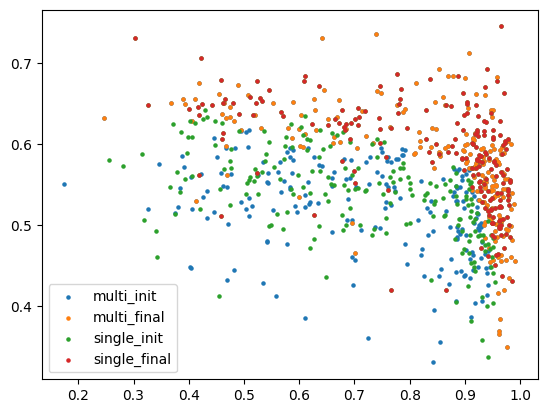

In [30]:
plt.scatter(x = scores_multi_init[:,0], y = scores_multi_init[:,1], s =5,label = 'multi_init')
plt.scatter(x = scores_multi_sel[:,0], y = scores_multi_sel[:,1], s =5, label = 'multi_final')
plt.scatter(x = scores_single_init[:,0], y = scores_single_init[:,1], s =5,label = 'single_init')
plt.scatter(x = scores_single_sel[:,0], y = scores_single_sel[:,1], s =5, label = 'single_final')
plt.legend()
plt.show()

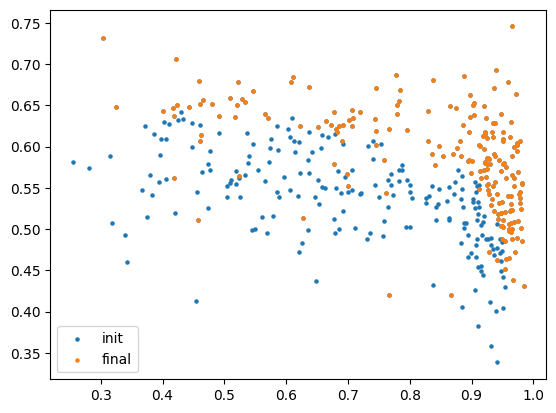

In [101]:
plt.scatter(x = scores_single_init[:,0], y = scores_single_init[:,1], s =5,label = 'init')
plt.scatter(x = scores_single_sel[:,0], y = scores_single_sel[:,1], s =5, label = 'final')
plt.legend()
plt.show()

In [110]:
from NSGA.utils import NSGAUtils
from NSGA import NSGAPopulation
from plan import Individual

In [140]:
def get_population(when,type):
    col_names = []
    for i in range(15):
        col_names.append(f'Dish Id {i+1}')
        col_names.append(f'Dish Qty {i+1}')
    df = pd.read_csv(output_base_path+f"{when}_gen_{type}.csv",header=None,names=col_names,index_col=False)
    all_data = df.values
    scores = []
    pop = NSGAPopulation()
    for plan_id,plan in enumerate(all_data):
        meal_plan = []
        for i in range(0,len(plan)-1,2):
            dish_index = i//2
            dish_id = plan[i]
            dish_qty = plan[i+1]
            meal = "Breakfast"
            if dish_index > 2 and dish_index <= 7:
                meal = "Lunch"
            elif dish_index > 7 and dish_index <= 9:
                meal = "Snacks"
            elif dish_index > 9:
                meal = "Dinner"
            if dish_id == 0:
                dish = Dish.get_padding_dish()
            else:
                dish = Dish(
                    id = str(dish_id),
                    quantity = dish_qty,
                    vector = data.get_dish_vector(dish_id),
                    title = data.get_dish_title(dish_id),
                    meal = meal,
                    cuisine = data.get_dish_cuisine(dish_id),
                    tags = data.get_dish_cuisine(dish_id),
                    category = data.get_dish_category(dish_id)
                )
            meal_plan.append(dish)
        all_single[0]["planning"]["weights"] = [1,1,1]
        all_single[0]["planning"]["num_objectives"] = 1
        problem_config=ProblemConfig(**all_single[0])
        meal_plan = MealPlan(problem_config,data,meal_plan)
        ind = Individual(meal_plan)
        pop.append(ind)
    return pop

In [141]:
pop_init_single = get_population('first','single')

In [142]:
hasattr(pop_init_single[0].meal_plan.problem_config.planning,'weights')

True

In [143]:
problem_config=ProblemConfig(**all_single[0])
problem_config.planning.num_objectives = 1
problem_config.planning.weights = [1,1,1]
utils = NSGAUtils(data,problem_config)

In [144]:
for ind in pop_init_single:
    ind.calculate_objectives()

In [145]:
utils.fast_nondominated_sort(pop_init_single)

In [146]:
pop_init_single[0].objectives

[1.3998983190635983]

In [147]:
ranks = set([ind.rank for ind in pop_init_single])

In [148]:
max(ranks)

400

### Over the generations

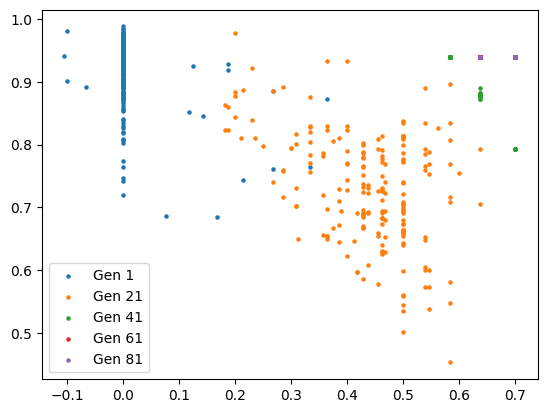

In [56]:
for i in range(1,100,20):
    scores = get_scores(f'selected_{i}','single')
    plt.scatter(scores[:,2],scores[:,0],s=5,label =f'Gen {i}')
plt.legend()
plt.show()

In [33]:
import plotly.graph_objects as go

fig = go.Figure()
scores = get_scores(f'selected_81','multi')
fig.add_trace(go.Scatter3d(x=scores[:,0], y=scores[:,1],z= scores[:,2],mode='markers',name='multi'))
scores = get_scores(f'selected_81','single')
fig.add_trace(go.Scatter3d(x=scores[:,0], y=scores[:,1],z= scores[:,2],mode='markers',name='multi'))
fig.show()

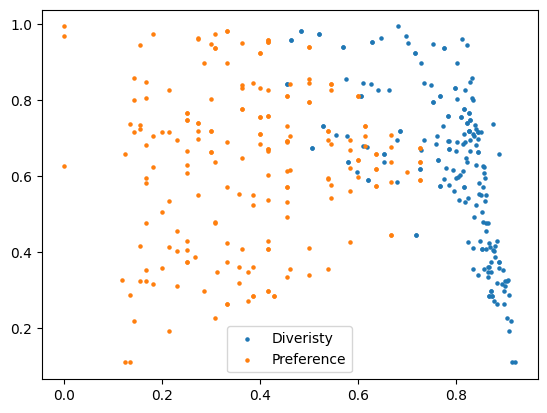

In [61]:
for i in range(81,100,20):
    scores = get_scores(f'selected_{i}','multi')
    plt.scatter(scores[:,1],scores[:,0],s=5,label =f'Diveristy')
    plt.scatter(scores[:,2],scores[:,0],s=5,label =f'Preference')
plt.legend()
plt.show()